In [1]:
# Versión más reciente para el Análisis de Temperatura y Densidad Atómica para espectro de Rubidio.

In [2]:
%run constants.py # Correr esta celda en caso de que se haya actualizado alguna constante dentro del json

In [3]:
import os 
import numpy as np 
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from pathlib import Path
from scipy.optimize import curve_fit
import scipy.constants as cte
from scipy import special
from lmfit import Parameters, Model
from scipy.signal import find_peaks

import tools

# Caracterización de Temperatura y Densidad Atómica

### Extracción de datos

In [4]:
with open('constants.json', 'r') as openfile:
    vals = json.load(openfile) # Reading constants from json file

In [5]:
dates = [20241120, 20250410]
date =  dates[1] # se elige la fecha de la toma de datos
take, Tset = '0006', 55 # se elige la toma de datos del día y su respectiva temperatura establecida (°C)
TSET = f'TSET_{Tset}'
data_path = f'../data/{date}_lineal_polarization/'
cols = ['TIME','SPECTRA','ABS'] # (tiempo, espectro, absorción)
data = pd.read_csv(data_path +f'/raw/ALL{take}/F{take}CH1.csv', names = ['TIME', TSET], usecols = [3,4]) # cambiar los canales de ser necesario
test = pd.read_csv(data_path +f'/raw/ALL{take}/F{take}CH2.csv', names = ['TIME', 'SPECTRA'], usecols = [3,4]) # [460:2000] 
test.SPECTRA = test.SPECTRA*0.1 #se multiplica por el factor de relación entre las intensidades de las señales (es modificable)

### Procesamiento de señales

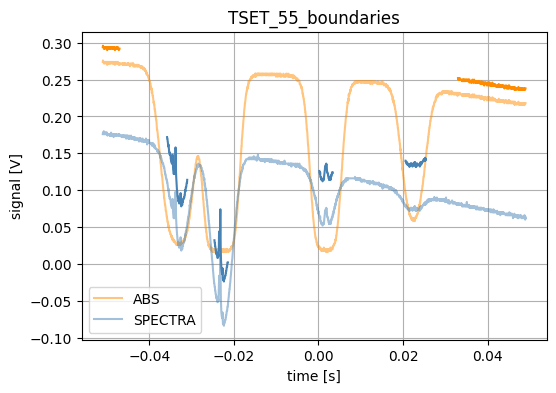

In [6]:
''' VISUALIZACIÓN '''

noise_bound = [0,100, 1000, 1000, 1600, 1600, 2100, 2500] #[0,100, 1000, 1000, 1600, 1600, 2100, 2500], [0,10, 650, 750, 1600, 1600, 1510, 2500]
frec_bound = [380, 500, 660, 740, 1280, 1360, 1790, 1910] # [400, 520, 1800, 1900], [200, 300, 1300, 1450] 
dx = 0.02

fig = plt.figure(figsize=(6,4))
plt.title(f'{TSET}_boundaries')
plt.plot(data.TIME,data[TSET], "darkorange", label = "ABS", alpha =0.5)
plt.plot(test.TIME,test.SPECTRA, "steelblue", label = "SPECTRA", alpha = 0.5)
plt.xlabel('time [s]'), plt.ylabel('signal [V]'), plt.grid()

# Secciones constantes para ajuste de ruido de fondo
# Secciones de máximos para la frecuencia
for i in range(0,4):
    plt.plot(data.TIME[noise_bound[2*i]:noise_bound[2*i+1]], data[TSET][noise_bound[2*i]:noise_bound[2*i+1]]+dx, "darkorange")
    plt.plot(test.TIME[frec_bound[2*i]:frec_bound[2*i+1]], test.SPECTRA[frec_bound[2*i]:frec_bound[2*i+1]]+dx*3, "steelblue")
    
plt.legend()

plt.show()

In [7]:
'''BUSQUEDA DE PICOS'''
peaks = []
for i in range(0,4):
    peak, _ = find_peaks(test.SPECTRA[frec_bound[2*i]:frec_bound[2*i+1]], threshold = 0, prominence = 0.0041, distance = 7)
    peak+= frec_bound[2*i]
    peaks.append(peak)
    print(f'Peaks in {i+1}: {peak}') # total peaks [3,3,1,1]
    
#peaks[2] = [1317] 
#peaks[3] = [1851]

Peaks in 1: [413 430 460]
Peaks in 2: [688 695 708]
Peaks in 3: [1321]
Peaks in 4: [1843]


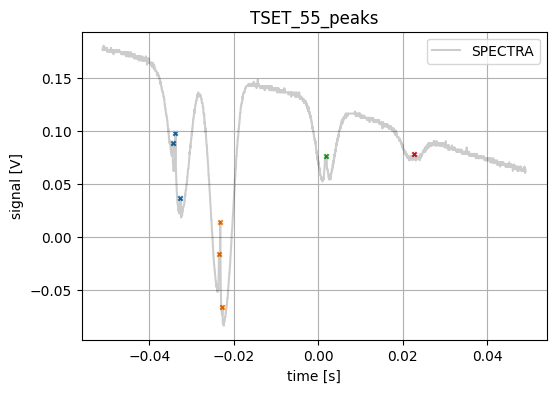

In [8]:
fig = plt.figure(figsize=(6,4))
plt.title(f'{TSET}_peaks')

plt.plot(test.TIME,test.SPECTRA, "black", label = "SPECTRA", alpha = 0.2)
for i in range(0,4):
    plt.scatter(test.TIME[peaks[i]], test.SPECTRA[peaks[i]], s = 10, alpha = 1, marker = "x")
    
plt.xlabel('time [s]'), plt.ylabel('signal [V]'), plt.grid()
plt.legend()
plt.show()

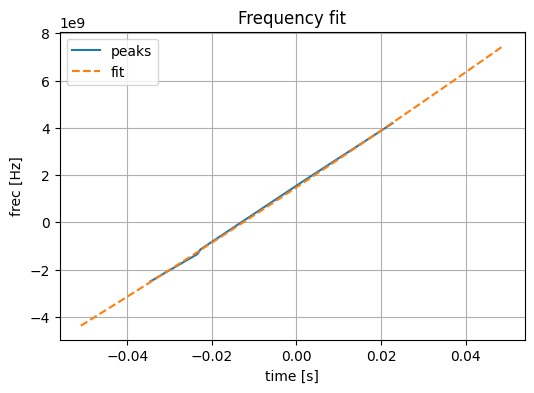

In [9]:
''' AJUSTE DE FRECUENCIA '''
#ptest, test['FREC'] = tools.adjust_frec_quad(test.TIME, min) # espectro
#pdata, data['FREC'] = tools.adjust_frec_quad(data.TIME, min) # temperatura

data['FREC'] = tools.adjust_frec_peaks(data.TIME, peaks)

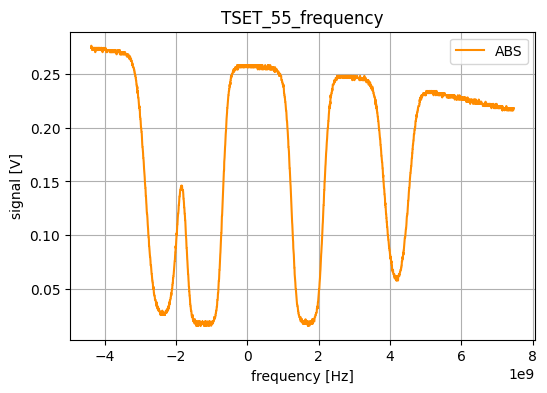

In [10]:
fig = plt.figure(figsize=(6,4))
plt.title(f'{TSET}_frequency')

plt.plot(data.FREC,data[TSET], "darkorange", label = "ABS")
#plt.plot(test.FREC,test.SPECTRA, "steelblue", label = "SPECTRA")
plt.xlabel('frequency [Hz]'), plt.ylabel('signal [V]'), plt.grid()
plt.legend()

plt.show()

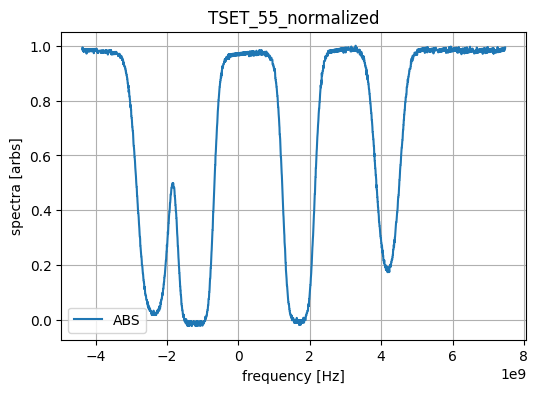

In [11]:
''' RUIDO DE FONDO Y NORMALIZACIÓN'''
noise = 0.0798 # 0.0498 # 0.108
#test['NORM'] = tools.adjust_noise(test.SPECTRA, test.TIME, bound, noise)
data['NORM'] = tools.adjust_noise(data[TSET], data.TIME, noise_bound, noise)

fig = plt.figure(figsize=(6,4))
plt.title(f'{TSET}_normalized')

plt.plot(data.FREC, data.NORM, label = "ABS")
#plt.plot(test.FREC, test.NORM, label = "SPECTRA")
plt.xlabel('frequency [Hz]'), plt.ylabel('spectra [arbs]'), plt.grid()
plt.legend()

plt.show()

### Análisis de datos

In [12]:
''' CÁLCULO DE TEMPERATURA Y DENSIDAD ESPERADOS'''
T_exp = Tset+273.15
N_exp = tools.density(vals['Rb_liquid_NES'], T_exp, 1) # 101325
exp_params = { "T" : T_exp, "N" : N_exp, "x0" : 0}

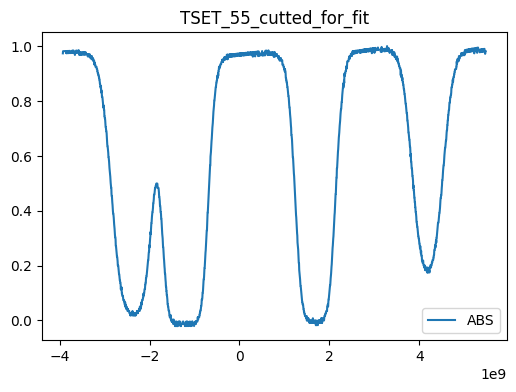

In [13]:
''' AJUSTRE SOBRE EL ESPECTRO DE ABSORCIÓN'''
delta = np.arange(-4e9, 5.5e9, 1e6)
fit_model = Model(tools.absorption_p) 

# inicialización de parámetros
p = Parameters()
p.add('T', T_exp,min=T_exp-1, max=T_exp+1)
p.add('N',N_exp,  min=N_exp*1e-1, max=N_exp*1e1)
p.add('x0',0, vary=True)
x = data.FREC[100:2100]
y = data.NORM[100:2100]

fig = plt.figure(figsize=(6,4))
plt.title(f'{TSET}_cutted_for_fit')
plt.plot(x, y, label = 'ABS')
plt.legend()
plt.show()

[[Model]]
    Model(absorption_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 92
    # data points      = 2000
    # variables        = 3
    chi-square         = 1.87965245
    reduced chi-square = 9.4124e-04
    Akaike info crit   = -13933.6311
    Bayesian info crit = -13916.8284
    R-squared          = 0.99403226
[[Variables]]
    T:   329.150000 +/- 4.08092612 (1.24%) (init = 328.15)
    N:   6.1535e+16 +/- 3.0630e+14 (0.50%) (init = 1.636037e+17)
    x0: -17756317.7 +/- 620358.925 (3.49%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(T, N)  = +0.6695
    C(T, x0) = -0.1037


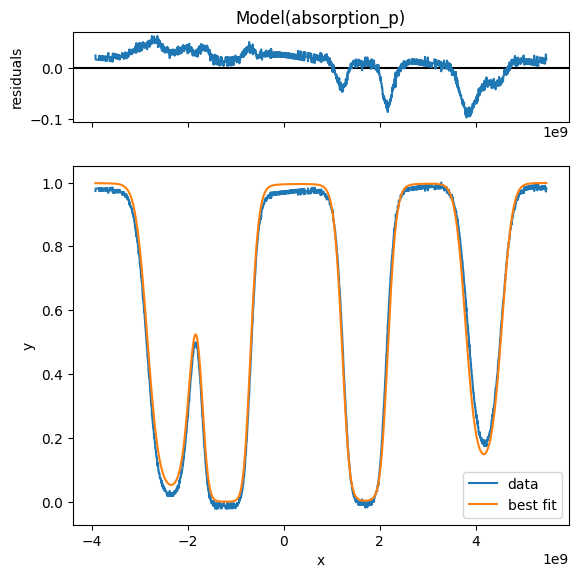

In [15]:
''' AJUSTE ACTUAL'''
# leastsq’: Levenberg-Marquardt (default)
#’least_squares’: Least-Squares minimization, using Trust Region Reflective method
result = fit_model.fit(y, x=x, params=p, nan_policy='raise',method='leastsq')
fit_params = result.params.valuesdict()
# exctract the AD
report = result.fit_report()
print(report)

fig = result.plot('-')

In [16]:
''' GUARDAR PARÁMETROS, REPORTES Y GRAFICAS'''
tools.create_directory(f'../records/{date}')
tools.create_directory(f'../records/{date}/plots')
tools.create_directory(f'../records/{date}/reports')

fig.savefig(f'../records/{date}/plots/{TSET}.png') # save plot as png
f = open(f'../records/{date}/reports/{TSET}.txt', 'w') # save report as txt
f.write(report)
f.close()

with open(f'../records/{date}/fit_records.csv', 'a', newline='') as csvfile: # save fit params in csv
    fieldnames = ['T', 'N', 'x0']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writerows([fit_params])

with open(f'../records/{date}/exp_records.csv', 'a', newline='') as csvfile: #save expected params in csv
    fieldnames = ['T', 'N', 'x0']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writerows([exp_params])

print(f'{TSET} data saved successfully')

Directory '../records/20250410' already exists.
Directory '../records/20250410/plots' already exists.
Directory '../records/20250410/reports' already exists.
TSET_55 data saved successfully
